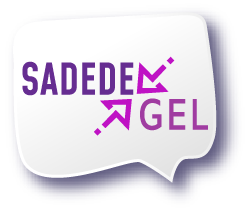

## Ürün yorumlarından duygu analizi
### with Sadedegel and Sklearn
#### by Global Maksimum DS Team

In [ ]:
!pip install sadedegel
import torch
import numpy as np
import pandas as pd
from sadedegel.bblock import Doc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import vstack, csr_matrix # dealing with sparse matrices in  tfidf embeddings
from sklearn.preprocessing import normalize
import altair as alt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer



### Data

In [ ]:
df = pd.read_csv("../input/duygu-analizi-icin-urun-yorumlari/magaza_yorumlari_duygu_analizi.csv", encoding="utf-16")
df

Datasette **Olumsuz**, **Tarafsız** ve **Olumlu** diye ayrılan 11428 tane ürün yorumu bulunmaktadır.

In [ ]:
df.isna().value_counts()

In [ ]:
df = df.dropna()
df

## Preprocessing

### Sklearn


<br>
Datamızı yükledikten sonra ham metni TF-IDF embedding matrisine çevireceğiz.

- Önce birkaç örnek metin alacağız,
- Bu metinlerin vocabulary olarak gösterimi,
- TF-IDF değerleri


In [ ]:
# let's take 5 examples

text = df.iloc[:5]['Görüş'].tolist()
print(text)

In [ ]:
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# vocab
print(vectorizer.vocabulary_)

In [ ]:
# transforming text to tf-idf values
transformed_text=vectorizer.transform(text)
# converting array to dataframe
transformed_text=pd.DataFrame.sparse.from_spmatrix(transformed_text)
transformed_text
# renaming vocab columns
mapped_text=transformed_text.rename(columns={v: k for k, v in vectorizer.vocabulary_.items()})
mapped_text

In [ ]:
mapped_text['aldım']

## Sadedegel

Her bir doküman (bizim durumda her bir yorum) için aşağıdaki adımlar uygulanacaktır:
<ol>
    <li style="font-weight:bold"><span style="font-weight:normal">Yorum, Sadedegel Doc objesine çevrilir.</span></li>
    <li style="font-weight:bold"><span style="font-weight:normal">Doc objesinin .tfidf attribute'undan V boyutunda bir vektör alınır (N: Dokümandaki cümle sayısı, V: Vocabulary boyutu)</span></li>
    <li style="font-weight:bold"><span style="font-weight:normal">Oluşan V boyutunda vektör sınıflandırıcya verilir.</span></li>
</ol>

1 doküman (yorum) üstünde tüm preprocessing adımları:

In [ ]:
# Step 1
doc_0 = Doc(df.iloc[0]["Görüş"])
doc_0

In [ ]:
# Step 2
tfidf_embedding_0 = doc_0.tfidf
tfidf_embedding_0.shape

Geriye kalan tek şey sınıflandırıcıyı eğitmek için bir matris oluşturmak.

In [ ]:

X_str = df["Görüş"]
X = []

for txt in tqdm(X_str):
    d = Doc(txt)
    X.append(d.tfidf)


X = np.stack(X, axis=0)
print("Shape of embeddings matrix: ", X.shape)

Datamızı hazırlamanın son adımı train ve test bölümlerine bölmek:

In [ ]:
y = df["Durum"]
X_train, X_val, y_train, y_val = train_test_split(X,y, stratify=df["Durum"], test_size=0.2)

---

### Train and validate

Şimdi sıra modellemede. Eğitimi hızlı olsun diye en basit sınıflandırma metodunu, LogisticRegression'ı kullanacağız.

In [ ]:
clf = RandomForestClassifier().fit(X_train, y_train) # train

Sınıflandırma modelimiz hazır!
Test datasının üstünde deneme vakti.

In [ ]:
y_pred = clf.predict(X_val)
y_pred

Modelimizin performansını ölçmek için accuracy metriğini kullanacağız.

In [ ]:
from sklearn.metrics import  accuracy_score

print("Accuracy:", accuracy_score(y_val, y_pred, normalize=True))